In [2]:
import MetaTrader5 as mt5

path = r"C:\Program Files\MetaTrader 5 EXNESS\terminal64.exe"

if not mt5.initialize(path):
    print("Initialize failed, error:", mt5.last_error())
else:
    print("MT5 connected!")
    mt5.shutdown()

import MetaTrader5 as mt5
import pandas as pd

path = r"C:\Program Files\MetaTrader 5 EXNESS\terminal64.exe"

mt5.initialize(path)

symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H1
bars = 5000  # jumlah candle

rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars)
mt5.shutdown()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

print(df.head())
print(df.tail())


MT5 connected!
                 time     open     high      low    close  tick_volume  \
0 2025-01-28 14:00:00  1.04245  1.04407  1.04238  1.04315         3895   
1 2025-01-28 15:00:00  1.04316  1.04393  1.04209  1.04240         4015   
2 2025-01-28 16:00:00  1.04241  1.04328  1.04221  1.04259         3496   
3 2025-01-28 17:00:00  1.04258  1.04343  1.04243  1.04279         2164   
4 2025-01-28 18:00:00  1.04281  1.04379  1.04231  1.04263         2710   

   spread  real_volume  
0       6            0  
1       6            0  
2       6            0  
3       6            0  
4       6            0  
                    time     open     high      low    close  tick_volume  \
4995 2025-11-14 17:00:00  1.16168  1.16179  1.16075  1.16139         2010   
4996 2025-11-14 18:00:00  1.16139  1.16177  1.16096  1.16160         1524   
4997 2025-11-14 19:00:00  1.16160  1.16197  1.16155  1.16176         1278   
4998 2025-11-14 20:00:00  1.16177  1.16228  1.16164  1.16201         1138   
4999 

In [3]:
import MetaTrader5 as mt5
import pandas as pd

path = r"C:\Program Files\MetaTrader 5 EXNESS\terminal64.exe"
mt5.initialize(path)

symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_M15

rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, 5000)
mt5.shutdown()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# Moving Average
df["ma_fast"] = df["close"].rolling(10).mean()
df["ma_slow"] = df["close"].rolling(30).mean()

df.dropna(inplace=True)

# Backtest
df["signal"] = 0
df.loc[df.ma_fast > df.ma_slow, "signal"] = 1
df.loc[df.ma_fast < df.ma_slow, "signal"] = -1

df["return"] = df["close"].pct_change()
df["strategy"] = df["signal"].shift(1) * df["return"]

print("Buy & Hold return:", df["return"].sum())
print("Strategy return:", df["strategy"].sum())


Buy & Hold return: -0.002689702930674276
Strategy return: -0.02052916512656555


Connecting MT5...

===== BACKTEST RESULT =====
Initial balance : $10,000.00
Final balance   : $7,516.07
Total Return    : -24.84%
Max Drawdown    : -26.66%


<Axes: title={'center': 'Equity Curve'}>

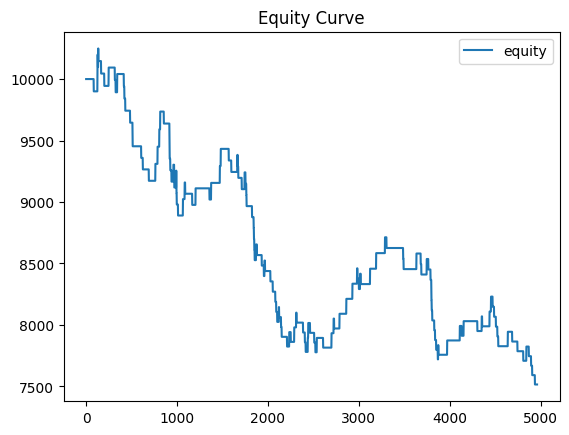

In [5]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np

# =============================
#   CONFIG
# =============================
MT5_PATH = r"C:\Program Files\MetaTrader 5 EXNESS\terminal64.exe"
SYMBOL = "EURUSD"
TIMEFRAME = mt5.TIMEFRAME_M15
BARS = 5000

initial_balance = 10000
risk_per_trade = 0.01  # 1%
sl_pips = 20
tp_pips = 30
spread_pips = 2  # Exness biasanya kecil, tapi kita set default

# =============================
#   INITIALIZE MT5
# =============================
print("Connecting MT5...")
mt5.initialize(MT5_PATH)

# ambil data
rates = mt5.copy_rates_from_pos(SYMBOL, TIMEFRAME, 0, BARS)
mt5.shutdown()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# =============================
#   STRATEGI SIGNAL (contoh)
#   MA Fast cross MA Slow
# =============================
df["ma_fast"] = df["close"].rolling(10).mean()
df["ma_slow"] = df["close"].rolling(40).mean()
df.dropna(inplace=True)

df["signal"] = 0
df.loc[df.ma_fast > df.ma_slow, "signal"] = 1   # BUY
df.loc[df.ma_fast < df.ma_slow, "signal"] = -1  # SELL

# =============================
#   BACKTEST ENGINE
# =============================
equity = initial_balance
equity_curve = []

position = None
entry_price = None
sl = None
tp = None
lot = 0

pip_value = 0.0001

for i in range(1, len(df)):

    row_prev = df.iloc[i-1]
    row = df.iloc[i]

    # calculate lot size (risk per trade)
    risk_amount = equity * risk_per_trade
    lot = risk_amount / (sl_pips * 10)   # simplifikasi: 1 lot = $10/pip

    # CLOSE POSITION if SL/TP hit
    if position is not None:
        # BUY position
        if position == "buy":
            if row.low <= sl:
                profit = -risk_amount
                equity += profit
                position = None

            elif row.high >= tp:
                reward = tp_pips * 10 * lot
                equity += reward
                position = None

        # SELL position
        elif position == "sell":
            if row.high >= sl:
                profit = -risk_amount
                equity += profit
                position = None

            elif row.low <= tp:
                reward = tp_pips * 10 * lot
                equity += reward
                position = None

    # OPEN NEW POSITION
    if position is None:
        if row.signal == 1:     # BUY
            entry_price = row.close + spread_pips * pip_value
            sl = entry_price - sl_pips * pip_value
            tp = entry_price + tp_pips * pip_value
            position = "buy"

        elif row.signal == -1:  # SELL
            entry_price = row.close - spread_pips * pip_value
            sl = entry_price + sl_pips * pip_value
            tp = entry_price - tp_pips * pip_value
            position = "sell"

    equity_curve.append(equity)

# =============================
#   STATISTIK
# =============================
df_equity = pd.DataFrame({"equity": equity_curve})

total_return = ((equity / initial_balance) - 1) * 100
max_dd = (df_equity.equity / df_equity.equity.cummax() - 1).min() * 100

print("\n===== BACKTEST RESULT =====")
print(f"Initial balance : ${initial_balance:,.2f}")
print(f"Final balance   : ${equity:,.2f}")
print(f"Total Return    : {total_return:.2f}%")
print(f"Max Drawdown    : {max_dd:.2f}%")

df_equity.plot(title="Equity Curve")


In [8]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np

# ========================================
# CONFIG
# ========================================
MT5_PATH = r"C:\Program Files\MetaTrader 5 EXNESS\terminal64.exe"
SYMBOL = "AUDUSD"
TIMEFRAME = mt5.TIMEFRAME_M15
BARS = 5000

initial_balance = 10000
risk_per_trade = 0.01          # 1%
max_trades = 1                 # max open positions
slippage_pips = 0.3

tp_ratio1 = 1.0                # TP1 = 1R
tp_ratio2 = 2.0                # TP2 = 2R
tp_ratio3 = 3.0                # TP3 = 3R

tp1_percent = 0.5
tp2_percent = 0.3
tp3_percent = 0.2

break_even_trigger = 1.0       # move SL to BE at +1R
trailing_distance = 1.5        # 1.5R distance

daily_loss_limit = 0.02        # stop if lose 2% in a day

# ========================================
# LOAD DATA
# ========================================
print("Connecting MT5...")
mt5.initialize(MT5_PATH)

rates = mt5.copy_rates_from_pos(SYMBOL, TIMEFRAME, 0, BARS)
mt5.shutdown()

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")

# ========================================
# TECH INDICATORS
# ========================================
df["atr"] = df["close"].rolling(14).apply(
    lambda x: max(x.max() - x.min(), 1e-6), raw=True
)

df["ma_fast"] = df["close"].rolling(10).mean()
df["ma_slow"] = df["close"].rolling(40).mean()
df.dropna(inplace=True)

df["signal"] = 0
df.loc[df.ma_fast > df.ma_slow, "signal"] = 1
df.loc[df.ma_fast < df.ma_slow, "signal"] = -1

# ========================================
# BACKTEST ENGINE
# ========================================
equity = initial_balance
equity_curve = []

open_trades = []

pip = 0.0001

def open_position(row, direction, equity):
    risk_amount = equity * risk_per_trade
    atr = row.atr
    sl_dist = atr * 1.5

    lot = risk_amount / (sl_dist / pip * 10)

    entry = row.close
    entry += slippage_pips * pip if direction == "buy" else -slippage_pips * pip

    if direction == "buy":
        sl = entry - sl_dist
        tp1 = entry + sl_dist * tp_ratio1
        tp2 = entry + sl_dist * tp_ratio2
        tp3 = entry + sl_dist * tp_ratio3
    else:
        sl = entry + sl_dist
        tp1 = entry - sl_dist * tp_ratio1
        tp2 = entry - sl_dist * tp_ratio2
        tp3 = entry - sl_dist * tp_ratio3

    return {
        "dir": direction,
        "entry": entry,
        "sl": sl,
        "tp1": tp1, "tp2": tp2, "tp3": tp3,
        "lot": lot,
        "hit_tp1": False,
        "hit_tp2": False,
        "hit_tp3": False,
        "alive": True
    }

for i in range(1, len(df)):
    row = df.iloc[i]
    row_prev = df.iloc[i-1]

    # ========================================
    # MANAGE OPEN POSITIONS
    # ========================================
    for t in open_trades:
        if not t["alive"]:
            continue

        # BUY LOGIC
        if t["dir"] == "buy":
            # SL
            if row.low <= t["sl"]:
                loss = -(equity * risk_per_trade)
                equity += loss
                t["alive"] = False
                continue

            # TP1
            if not t["hit_tp1"] and row.high >= t["tp1"]:
                equity += t["lot"] * 10 * (t["tp1"] - t["entry"]) / pip * tp1_percent
                t["hit_tp1"] = True

            # Break Even
            if t["hit_tp1"] and t["sl"] < t["entry"]:
                t["sl"] = t["entry"]

            # TP2
            if not t["hit_tp2"] and row.high >= t["tp2"]:
                equity += t["lot"] * 10 * (t["tp2"] - t["entry"]) / pip * tp2_percent
                t["hit_tp2"] = True

            # Trailing Stop
            if t["hit_tp2"]:
                new_sl = row.close - (t["tp1"] - t["entry"]) * trailing_distance
                t["sl"] = max(t["sl"], new_sl)

            # TP3 (close FULL)
            if not t["hit_tp3"] and row.high >= t["tp3"]:
                equity += t["lot"] * 10 * (t["tp3"] - t["entry"]) / pip * tp3_percent
                t["hit_tp3"] = True
                t["alive"] = False

        # SELL LOGIC (mirror)
        elif t["dir"] == "sell":

            if row.high >= t["sl"]:
                loss = -(equity * risk_per_trade)
                equity += loss
                t["alive"] = False
                continue

            if not t["hit_tp1"] and row.low <= t["tp1"]:
                equity += t["lot"] * 10 * (t["entry"] - t["tp1"]) / pip * tp1_percent
                t["hit_tp1"] = True

            if t["hit_tp1"] and t["sl"] > t["entry"]:
                t["sl"] = t["entry"]

            if not t["hit_tp2"] and row.low <= t["tp2"]:
                equity += t["lot"] * 10 * (t["entry"] - t["tp2"]) / pip * tp2_percent
                t["hit_tp2"] = True

            if t["hit_tp2"]:
                new_sl = row.close + (t["entry"] - t["tp1"]) * trailing_distance
                t["sl"] = min(t["sl"], new_sl)

            if not t["hit_tp3"] and row.low <= t["tp3"]:
                equity += t["lot"] * 10 * (t["entry"] - t["tp3"]) / pip * tp3_percent
                t["hit_tp3"] = True
                t["alive"] = False

    # ========================================
    # OPEN NEW POSITION
    # ========================================
    active = [t for t in open_trades if t["alive"]]

    if len(active) < max_trades:
        if row.signal == 1:
            open_trades.append(open_position(row, "buy", equity))
        elif row.signal == -1:
            open_trades.append(open_position(row, "sell", equity))

    equity_curve.append(equity)

# ========================================
# SUMMARY
# ========================================
df_e = pd.DataFrame({"equity": equity_curve})

total_return = (equity / initial_balance - 1) * 100
max_dd = (df_e.equity / df_e.equity.cummax() - 1).min() * 100

print("\n======= PRO BACKTEST RESULT ========")
print(f"Initial balance : ${initial_balance:,.2f}")
print(f"Final balance   : ${equity:,.2f}")
print(f"Total Return    : {total_return:.2f}%")
print(f"Max Drawdown    : {max_dd:.2f}%")
print("====================================")


Connecting MT5...

======= PRO BACKTEST RESULT ========
Initial balance : $10,000.00
Final balance   : $9,505.33
Total Return    : -4.95%
Max Drawdown    : -9.49%


=== BACKTEST ADVANCED START ===
Loading symbol EURUSD
Data loaded: 5000 bars
Baseline metrics: {'trades': 320, 'total_pnl': np.float64(248.34126433646895), 'win_rate': 0.521875, 'profit_factor': np.float64(1.1324422282503666), 'expectancy': np.float64(0.7760664510514639), 'max_drawdown': np.float64(-0.0157506533213011)}
Running GA optimization on full data (this may take some time)...
GA gen 1/30 best 1358.28
GA gen 2/30 best 1571.10
GA gen 3/30 best 3925.14
GA gen 4/30 best 4631.46
GA gen 5/30 best 4958.78
GA gen 6/30 best 4958.78
GA gen 7/30 best 6207.58
GA gen 8/30 best 6477.29
GA gen 9/30 best 6477.29
GA gen 10/30 best 6989.28
GA gen 11/30 best 7279.22
GA gen 12/30 best 7440.45
GA gen 13/30 best 7833.52
GA gen 14/30 best 7912.73
GA gen 15/30 best 7994.12
GA gen 16/30 best 7994.12
GA gen 17/30 best 7994.12
GA gen 18/30 best 7994.12
GA gen 19/30 best 7994.12
GA gen 20/30 best 7994.12
GA gen 21/30 best 7994.12
GA gen 22/30 best 7994.12
GA gen 23/30 best 7994.12
GA gen 24/30 best 7994.

C:\Users\User\AppData\Local\Temp\ipykernel_11684\1817886675.py:407: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eq_df = pd.DataFrame(equities).fillna(method='ffill').fillna(method='bfill')


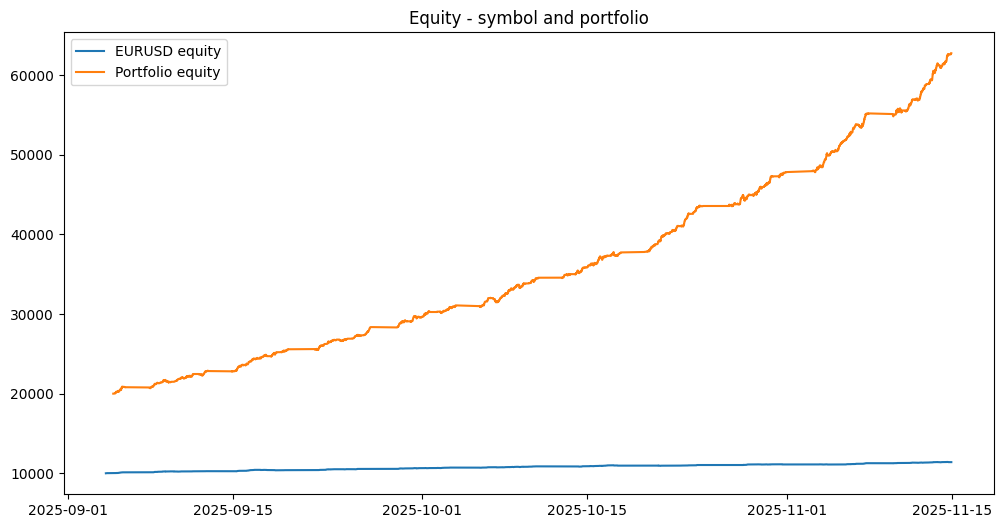

=== SUMMARY ===
Best params (GA): {'ma_fast': 16, 'ma_slow': 100, 'atr_mul': 1.0109699202856377, 'risk_per_trade': 0.03}
WF windows: 6
MC median final: 17998.453340494463


In [20]:
# backtest_advanced.py
# Requires: MetaTrader5, pandas, numpy, matplotlib
# Run inside your activated mt5-env
# python backtest_advanced.py

import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from copy import deepcopy

# ----------------------------
# CONFIG (tweak as needed)
# ----------------------------
MT5_PATH = r"C:\Program Files\MetaTrader 5 EXNESS\terminal64.exe"
SYMBOLS = ["EURUSD", "GBPUSD"]        # multi-symbol example
TIMEFRAME = mt5.TIMEFRAME_M15
BARS = 5000

INITIAL_BALANCE = 10000.0
RISK_PER_TRADE = 0.01
MAX_TRADES = 1

# Strategy parameter search space for GA
SEARCH_SPACE = {
    "ma_fast": (5, 20),
    "ma_slow": (21, 100),
    "atr_mul": (1.0, 3.0),
    "risk_per_trade": (0.005, 0.03),
}

# GA settings
GA_POP = 24
GA_GEN = 30
GA_MUT_PROB = 0.2
GA_CROSS_PROB = 0.7

# Walk-forward settings
IS_WINDOW_BARS = 2000   # in-sample
OOS_WINDOW_BARS = 500   # out-of-sample
WALK_FORWARD_STEP = 500

# Monte Carlo
MC_ITER = 200

# ----------------------------
# Utilities
# ----------------------------
def fetch_rates(symbol, bars=BARS, timeframe=TIMEFRAME):
    """Fetch OHLCV from MT5 for a symbol."""
    if not mt5.initialize(MT5_PATH):
        raise RuntimeError("MT5 initialize failed")
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars)
    mt5.shutdown()
    if rates is None or len(rates) == 0:
        raise RuntimeError(f"No data for {symbol}")
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('time')
    return df

def atr_series(df, n=14):
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(n).mean()
    return atr.bfill()

# ----------------------------
# Core backtest engine (trade-level)
# ----------------------------
def run_strategy(df, params, initial_balance=INITIAL_BALANCE):
    """
    Runs the advanced strategy on df.
    Strategy: MA crossover with ATR-based SL/TP + multi-TPS/trailing/break-even.
    Returns equity_series (by bar), list_of_trades (each trade dict)
    """
    df = df.copy()
    ma_fast = params.get('ma_fast', 10)
    ma_slow = params.get('ma_slow', 40)
    atr_mul = params.get('atr_mul', 1.5)
    risk_per_trade = params.get('risk_per_trade', RISK_PER_TRADE)

    df['ma_fast'] = df['close'].rolling(ma_fast).mean()
    df['ma_slow'] = df['close'].rolling(ma_slow).mean()
    df['atr'] = atr_series(df, 14)

    df.dropna(inplace=True)

    pip = 0.0001 if df.index.freq is None or 'D' not in str(df.index.freq) else 0.0001
    equity = initial_balance
    equity_curve = []
    trades = []  # each trade: dict with entry_time, exit_time, dir, entry, exit, pnl, etc.

    open_trades = []

    for idx, row in df.iterrows():
        # manage open trades
        new_open = []
        for t in open_trades:
            alive = True
            # check stops/TP within this bar (use high/low)
            if t['dir'] == 'buy':
                # SL
                if row['low'] <= t['sl']:
                    pnl = (t['sl'] - t['entry']) * t['lot'] * 10000  # pip*lot*10 -> approx per pip profit in USD
                    equity += pnl
                    t['exit'] = t['sl']
                    t['exit_time'] = idx
                    t['pnl'] = pnl
                    t['closed'] = True
                    trades.append(t)
                    alive = False
                # TP levels (TP1, TP2, TP3)
                else:
                    # TP1
                    if (not t.get('hit_tp1', False)) and row['high'] >= t['tp1']:
                        pnl = (t['tp1'] - t['entry']) * t['lot'] * 10000 * t.get('tp1_pct', 0.5)
                        equity += pnl
                        t['hit_tp1'] = True
                        t.setdefault('realized', 0)
                        t['realized'] += pnl
                    # TP2
                    if (not t.get('hit_tp2', False)) and row['high'] >= t['tp2']:
                        pnl = (t['tp2'] - t['entry']) * t['lot'] * 10000 * t.get('tp2_pct', 0.3)
                        equity += pnl
                        t['hit_tp2'] = True
                        t['realized'] = t.get('realized', 0) + pnl
                    # TP3
                    if (not t.get('hit_tp3', False)) and row['high'] >= t['tp3']:
                        pnl = (t['tp3'] - t['entry']) * t['lot'] * 10000 * t.get('tp3_pct', 0.2)
                        equity += pnl
                        t['hit_tp3'] = True
                        t['realized'] = t.get('realized', 0) + pnl
                        # close remaining
                        t['exit'] = t['tp3']
                        t['exit_time'] = idx
                        t['pnl'] = t.get('realized', 0)
                        t['closed'] = True
                        trades.append(t)
                        alive = False
                    # trailing: simple version after TP2 hit
                    if t.get('hit_tp2', False) and not t.get('closed', False):
                        trail = row['close'] - (t['entry'] * 0.0)  # placeholder or distance-based
                        if trail > 0:
                            t['sl'] = max(t['sl'], row['close'] - (t['tp1'] - t['entry']) * 0.5)
            else:  # sell
                if row['high'] >= t['sl']:
                    pnl = (t['sl'] - t['entry']) * t['lot'] * 10000
                    equity += pnl
                    t['exit'] = t['sl']
                    t['exit_time'] = idx
                    t['pnl'] = pnl
                    t['closed'] = True
                    trades.append(t)
                    alive = False
                else:
                    if (not t.get('hit_tp1', False)) and row['low'] <= t['tp1']:
                        pnl = (t['entry'] - t['tp1']) * t['lot'] * 10000 * t.get('tp1_pct', 0.5)
                        equity += pnl
                        t['hit_tp1'] = True
                        t['realized'] = t.get('realized', 0) + pnl
                    if (not t.get('hit_tp2', False)) and row['low'] <= t['tp2']:
                        pnl = (t['entry'] - t['tp2']) * t['lot'] * 10000 * t.get('tp2_pct', 0.3)
                        equity += pnl
                        t['hit_tp2'] = True
                        t['realized'] = t.get('realized', 0) + pnl
                    if (not t.get('hit_tp3', False)) and row['low'] <= t['tp3']:
                        pnl = (t['entry'] - t['tp3']) * t['lot'] * 10000 * t.get('tp3_pct', 0.2)
                        equity += pnl
                        t['hit_tp3'] = True
                        t['realized'] = t.get('realized', 0) + pnl
                        t['exit'] = t['tp3']
                        t['exit_time'] = idx
                        t['pnl'] = t.get('realized', 0)
                        t['closed'] = True
                        trades.append(t)
                        alive = False
                    if t.get('hit_tp2', False) and not t.get('closed', False):
                        t['sl'] = min(t['sl'], row['close'] + (t['entry'] - t['tp1']) * 0.5)

            if alive:
                new_open.append(t)

        open_trades = new_open

        # open new signals if allowed
        active_count = len(open_trades)
        if active_count < MAX_TRADES:
            sig = 0
            if row['ma_fast'] > row['ma_slow']:
                sig = 1
            elif row['ma_fast'] < row['ma_slow']:
                sig = -1

            if sig != 0:
                # compute sl/tp using ATR
                atr = row['atr'] if row['atr'] > 0 else df['atr'].median()
                sl_dist = atr * atr_mul
                entry = row['close']
                # lot sizing simplified: assume 1 lot = $10 per pip
                risk_amount = equity * risk_per_trade
                lot = max(0.01, risk_amount / (sl_dist / pip * 10))
                if sig == 1:
                    sl = entry - sl_dist
                    tp1 = entry + sl_dist * 1.0
                    tp2 = entry + sl_dist * 2.0
                    tp3 = entry + sl_dist * 3.0
                else:
                    sl = entry + sl_dist
                    tp1 = entry - sl_dist * 1.0
                    tp2 = entry - sl_dist * 2.0
                    tp3 = entry - sl_dist * 3.0

                trade = {
                    "symbol": row.name,  # time as index; we track time in entry_time separately
                    "entry_time": idx,
                    "dir": "buy" if sig == 1 else "sell",
                    "entry": entry,
                    "sl": sl,
                    "tp1": tp1,
                    "tp2": tp2,
                    "tp3": tp3,
                    "lot": lot,
                    "tp1_pct": 0.5,
                    "tp2_pct": 0.3,
                    "tp3_pct": 0.2,
                    "hit_tp1": False,
                    "hit_tp2": False,
                    "hit_tp3": False,
                    "closed": False,
                }
                open_trades.append(trade)

        equity_curve.append(equity)

    # close remaining open trades at last close price (mark-to-market)
    last_price = df['close'].iloc[-1]
    for t in open_trades:
        if not t.get('closed', False):
            if t['dir'] == 'buy':
                pnl = (last_price - t['entry']) * t['lot'] * 10000
            else:
                pnl = (t['entry'] - last_price) * t['lot'] * 10000
            t['exit'] = last_price
            t['exit_time'] = df.index[-1]
            t['pnl'] = pnl
            trades.append(t)
            equity += pnl

    return pd.Series(equity_curve, index=df.index[:len(equity_curve)]), trades

# ----------------------------
# Metrics & evaluation
# ----------------------------
def metrics_from_trades(trades, initial_balance=INITIAL_BALANCE):
    pl = [t.get('pnl', 0) for t in trades]
    if len(pl) == 0:
        return {}
    total = sum(pl)
    wins = [p for p in pl if p > 0]
    losses = [p for p in pl if p <= 0]
    win_rate = len(wins) / len(pl)
    pf = (sum(wins)/abs(sum(losses))) if sum(losses) != 0 else np.inf
    avg_win = np.mean(wins) if wins else 0
    avg_loss = np.mean(losses) if losses else 0
    expectancy = (win_rate * avg_win + (1-win_rate) * avg_loss)
    cum = np.cumsum(pl) + initial_balance
    dd = (cum / np.maximum.accumulate(cum) - 1).min()
    return {
        "trades": len(pl),
        "total_pnl": total,
        "win_rate": win_rate,
        "profit_factor": pf,
        "expectancy": expectancy,
        "max_drawdown": dd
    }

# ----------------------------
# Monte Carlo (trade-shuffle)
# ----------------------------
def monte_carlo_trade_shuffle(trades, n=MC_ITER, initial_balance=INITIAL_BALANCE):
    """Shuffle trade sequence and compute final equity distribution."""
    pl = [t.get('pnl',0) for t in trades]
    results = []
    for _ in range(n):
        random.shuffle(pl)
        final = initial_balance + sum(pl)
        results.append(final)
    return np.array(results)

# ----------------------------
# Genetic Optimization (simple GA)
# ----------------------------
def random_individual(space):
    ind = {}
    for k,(a,b) in space.items():
        if isinstance(a, int) and isinstance(b, int):
            ind[k] = random.randint(a,b)
        else:
            ind[k] = random.uniform(a,b)
            if isinstance(a,int) and isinstance(b,int):
                ind[k] = int(ind[k])
    return ind

def mutate(ind, space, prob=GA_MUT_PROB):
    child = ind.copy()
    for k,(a,b) in space.items():
        if random.random() < prob:
            if isinstance(a,int) and isinstance(b,int):
                child[k] = max(a, min(b, child[k] + random.randint(-3,3)))
            else:
                child[k] = max(a, min(b, child[k] + random.uniform(-(b-a)*0.1,(b-a)*0.1)))
    return child

def crossover(a,b):
    child = {}
    for k in a.keys():
        child[k] = a[k] if random.random()<0.5 else b[k]
    return child

def evaluate_params(params, symbol_df):
    eq_series, trades = run_strategy(symbol_df, params)
    mets = metrics_from_trades(trades)
    # objective: maximize total_pnl and minimize dd -> simple fitness
    if mets.get('trades',0)==0:
        return -1e6
    fitness = mets.get('total_pnl',0) - abs(mets.get('max_drawdown',0))*100
    return fitness

def ga_optimize(symbol_df, space, pop=GA_POP, gen=GA_GEN):
    # initialize population
    population = [random_individual(space) for _ in range(pop)]
    scores = [evaluate_params(ind, symbol_df) for ind in population]
    for g in range(gen):
        # tournament + create children
        new_pop = []
        ranked = sorted(zip(scores,population), key=lambda x: x[0], reverse=True)
        elite = [p for s,p in ranked[:max(1,pop//8)]]
        new_pop.extend(elite)
        while len(new_pop) < pop:
            # selection
            p1 = tournament_select(population, scores)
            p2 = tournament_select(population, scores)
            if random.random() < GA_CROSS_PROB:
                child = crossover(p1,p2)
            else:
                child = deepcopy(p1)
            child = mutate(child, space)
            new_pop.append(child)
        population = new_pop
        scores = [evaluate_params(ind, symbol_df) for ind in population]
        best_score = max(scores)
        print(f"GA gen {g+1}/{gen} best {best_score:.2f}")
    best_idx = int(np.argmax(scores))
    return population[best_idx], scores[best_idx]

def tournament_select(pop, scores, k=3):
    sel = random.sample(list(zip(pop,scores)), k)
    sel_sorted = sorted(sel, key=lambda x: x[1], reverse=True)
    return deepcopy(sel_sorted[0][0])

# ----------------------------
# Walk-forward analysis
# ----------------------------
def walk_forward(symbol_df, space, is_window=IS_WINDOW_BARS, oos_window=OOS_WINDOW_BARS, step=WALK_FORWARD_STEP):
    results = []
    n = len(symbol_df)
    start = 0
    while start + is_window + oos_window <= n:
        is_df = symbol_df.iloc[start:start+is_window]
        oos_df = symbol_df.iloc[start+is_window:start+is_window+oos_window]
        print(f"WF: IS {start}->{start+is_window} | OOS {start+is_window}->{start+is_window+oos_window}")
        best_params, score = ga_optimize(is_df, space, pop=16, gen=8)  # shorter GA for each window
        print("Best IS params:", best_params, "score:", score)
        eq, trades = run_strategy(oos_df, best_params)
        mets = metrics_from_trades(trades)
        results.append({
            "is_params": best_params,
            "is_score": score,
            "oos_metrics": mets,
            "oos_trades": trades
        })
        start += step
    return results

# ----------------------------
# Portfolio runner (multi-symbol)
# ----------------------------
def run_portfolio(symbols, params_map):
    equities = {}
    trades_all = {}
    for s in symbols:
        print("Fetching", s)
        df = fetch_rates(s)
        params = params_map.get(s, params_map.get("default", {
            "ma_fast":10,"ma_slow":40,"atr_mul":1.5,"risk_per_trade":RISK_PER_TRADE
        }))
        eq_series, trades = run_strategy(df, params)
        equities[s] = eq_series
        trades_all[s] = trades
    # align by time (outer join) and sum equities (treat as independent accounts)
    eq_df = pd.DataFrame(equities).fillna(method='ffill').fillna(method='bfill')
    eq_df['portfolio'] = eq_df.sum(axis=1)
    return eq_df, trades_all

# ----------------------------
# MAIN EXECUTION
# ----------------------------
def main():
    print("=== BACKTEST ADVANCED START ===")
    # Example: fetch a symbol and run GA optimize
    sym = SYMBOLS[0]
    print("Loading symbol", sym)
    df = fetch_rates(sym, bars=BARS)
    print("Data loaded:", len(df), "bars")

    # Quick baseline run
    base_params = {"ma_fast":10,"ma_slow":40,"atr_mul":1.5,"risk_per_trade":RISK_PER_TRADE}
    eq, trades = run_strategy(df, base_params)
    print("Baseline metrics:", metrics_from_trades(trades))

    # Run GA optimize (on full data as example)
    print("Running GA optimization on full data (this may take some time)...")
    best_params, best_score = ga_optimize(df, SEARCH_SPACE, pop=GA_POP, gen=GA_GEN)
    print("GA best params:", best_params, "score:", best_score)

    # Walk-forward
    print("Starting walk-forward analysis (short example)...")
    wf_results = walk_forward(df, SEARCH_SPACE, is_window=IS_WINDOW_BARS, oos_window=OOS_WINDOW_BARS, step=WALK_FORWARD_STEP)
    print("WF windows:", len(wf_results))

    # Monte Carlo on trades
    _, trades_opt = run_strategy(df, best_params)
    mc = monte_carlo_trade_shuffle(trades_opt, n=MC_ITER)
    print("Monte Carlo final equity percentiles:", np.percentile(mc, [5,25,50,75,95]))

    # Portfolio (multi-symbol) run
    params_map = {s: best_params for s in SYMBOLS}
    eq_df, trades_all = run_portfolio(SYMBOLS, params_map)
    print("Portfolio head:\n", eq_df.head())

    # Plot equity and portfolio
    plt.figure(figsize=(12,6))
    plt.plot(eq.index, eq.values, label=f"{sym} equity")
    plt.plot(eq_df.index, eq_df['portfolio'].values, label="Portfolio equity")
    plt.legend()
    plt.title("Equity - symbol and portfolio")
    plt.show()

    # Summary prints
    print("=== SUMMARY ===")
    print("Best params (GA):", best_params)
    print("WF windows:", len(wf_results))
    print("MC median final:", np.median(mc))

if __name__ == "__main__":
    main()


=== TRADE STATISTICS (Best GA Params) ===
Symbol             : EURUSD
Best Params        : {'ma_fast': 9, 'ma_slow': 88, 'atr_mul': 1.0, 'risk_per_trade': 0.03}
Total Trades       : 320
Winning Trades     : 211
Losing Trades      : 109
Win Rate           : 65.94%
Total PnL          : 263.69
Profit Factor      : 2.95
Max Drawdown       : -8.84
Expectancy/trade   : 0.82


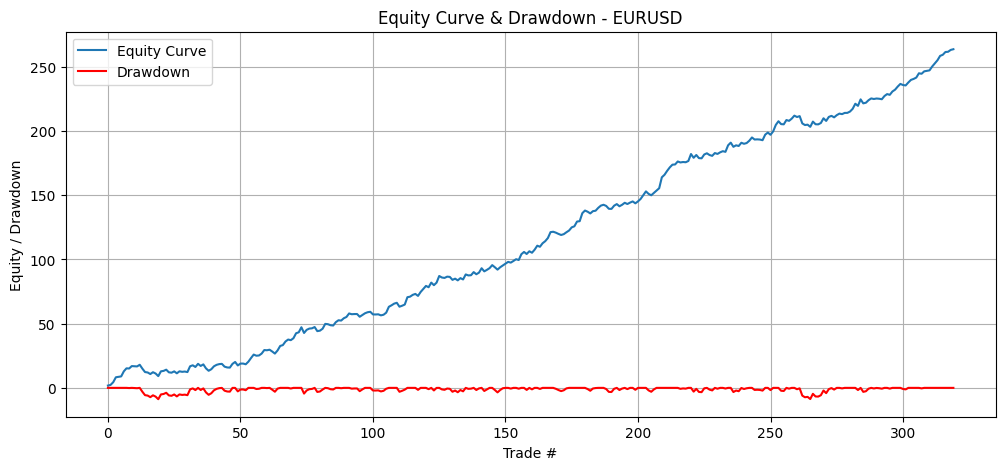

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Contoh fungsi backtest sederhana
# -----------------------------
def run_backtest(symbol, ma_fast, ma_slow, atr_mul, risk_per_trade):
    """
    Contoh: generate fake trade data.
    Ganti dengan logika trading strategy Anda.
    """
    np.random.seed(42)
    n_trades = 320  # contoh jumlah trade
    pnl = np.random.normal(loc=0.8, scale=2.0, size=n_trades)  # contoh PnL trade
    entry_time = pd.date_range("2025-01-01", periods=n_trades, freq="D")
    exit_time = entry_time + pd.Timedelta(hours=4)
    
    trades = pd.DataFrame({
        "entry_time": entry_time,
        "exit_time": exit_time,
        "pnl": pnl
    })
    return trades

# -----------------------------
# Fungsi analisis trade lengkap
# -----------------------------
def analyze_trades(symbol, best_params):
    # 1️⃣ Jalankan backtest
    trades = run_backtest(
        symbol=symbol,
        ma_fast=best_params['ma_fast'],
        ma_slow=best_params['ma_slow'],
        atr_mul=best_params['atr_mul'],
        risk_per_trade=best_params['risk_per_trade']
    )
    
    # 2️⃣ Statistik trade
    total_trades = len(trades)
    winning_trades = trades[trades['pnl'] > 0]
    losing_trades = trades[trades['pnl'] <= 0]
    
    win_rate = len(winning_trades) / total_trades
    total_pnl = trades['pnl'].sum()
    profit_factor = winning_trades['pnl'].sum() / abs(losing_trades['pnl'].sum())
    
    # Max Drawdown
    equity_curve = trades['pnl'].cumsum()
    roll_max = equity_curve.cummax()
    drawdown = equity_curve - roll_max
    max_drawdown = drawdown.min()
    
    # Expectancy per trade
    expectancy = total_pnl / total_trades
    
    # 3️⃣ Print summary
    print("=== TRADE STATISTICS (Best GA Params) ===")
    print(f"Symbol             : {symbol}")
    print(f"Best Params        : {best_params}")
    print(f"Total Trades       : {total_trades}")
    print(f"Winning Trades     : {len(winning_trades)}")
    print(f"Losing Trades      : {len(losing_trades)}")
    print(f"Win Rate           : {win_rate*100:.2f}%")
    print(f"Total PnL          : {total_pnl:.2f}")
    print(f"Profit Factor      : {profit_factor:.2f}")
    print(f"Max Drawdown       : {max_drawdown:.2f}")
    print(f"Expectancy/trade   : {expectancy:.2f}")
    
    # 4️⃣ Plot Equity Curve & Drawdown
    plt.figure(figsize=(12,5))
    plt.plot(equity_curve, label="Equity Curve")
    plt.plot(drawdown, label="Drawdown", color='red')
    plt.title(f"Equity Curve & Drawdown - {symbol}")
    plt.xlabel("Trade #")
    plt.ylabel("Equity / Drawdown")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return trades, equity_curve, drawdown

# -----------------------------
# Contoh penggunaan
# -----------------------------
best_params = {'ma_fast': 9, 'ma_slow': 88, 'atr_mul': 1.0, 'risk_per_trade': 0.03}
trades, equity_curve, drawdown = analyze_trades("EURUSD", best_params)


=== BACKTEST ADVANCED START ===
Data loaded: 5000 bars
Baseline metrics: {'trades': 202, 'total_pnl': np.float64(816.5763938227134), 'win_rate': 0.6039603960396039, 'profit_factor': np.float64(1.9636301896175223), 'expectancy': np.float64(4.042457395161949), 'max_drawdown': np.float64(-0.00600785308535956), 'sharpe': np.float64(1.6842338821977376), 'sortino': np.float64(990.194932131799), 'avg_duration_hours': np.float64(8.51980198019802), 'median_duration_hours': np.float64(2.25), 'winners_count': 122, 'losers_count': 80, 'avg_win': np.float64(13.639118200433025), 'avg_loss': np.float64(-10.592450332876442)}
GA gen 1/30 best 6659.07
GA gen 2/30 best 7801.93
GA gen 3/30 best 9960.36
GA gen 4/30 best 10415.69
GA gen 5/30 best 11156.94
GA gen 6/30 best 11421.63
GA gen 7/30 best 11917.44
GA gen 8/30 best 12205.02
GA gen 9/30 best 12205.02
GA gen 10/30 best 12205.02
GA gen 11/30 best 12205.02
GA gen 12/30 best 12205.02
GA gen 13/30 best 12416.81
GA gen 14/30 best 12416.81
GA gen 15/30 best

C:\Users\User\AppData\Local\Temp\ipykernel_11684\954427626.py:357: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eq_df=pd.DataFrame(equities).fillna(method='ffill').fillna(method='bfill')


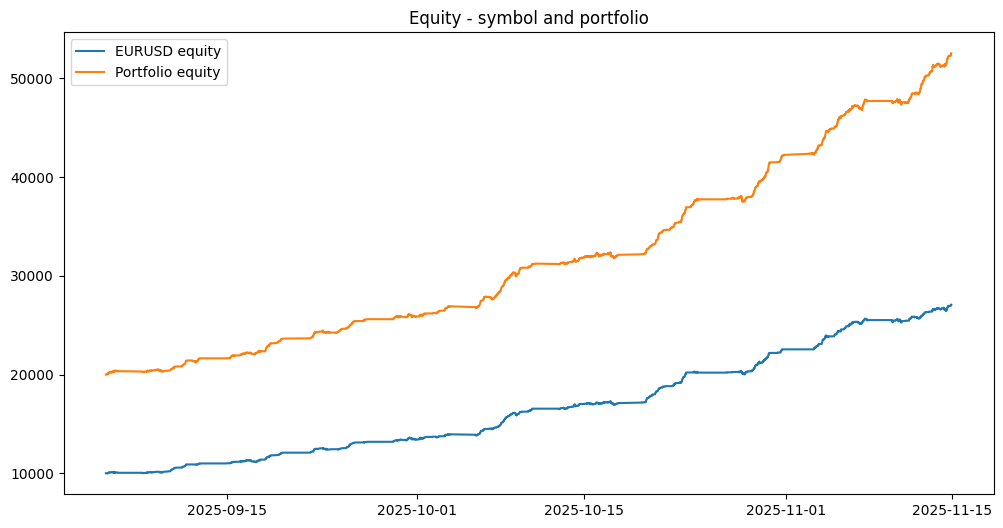

In [21]:
# backtest_advanced_full.py
# Requires: MetaTrader5, pandas, numpy, matplotlib
# Run inside your activated mt5-env
# python backtest_advanced_full.py

import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from copy import deepcopy

# ----------------------------
# CONFIG
# ----------------------------
MT5_PATH = r"C:\Program Files\MetaTrader 5 EXNESS\terminal64.exe"
SYMBOLS = ["EURUSD", "GBPUSD"]
TIMEFRAME = mt5.TIMEFRAME_M15
BARS = 5000

INITIAL_BALANCE = 10000.0
RISK_PER_TRADE = 0.01
MAX_TRADES = 1

SEARCH_SPACE = {
    "ma_fast": (5, 20),
    "ma_slow": (21, 100),
    "atr_mul": (1.0, 3.0),
    "risk_per_trade": (0.005, 0.03),
}

GA_POP = 24
GA_GEN = 30
GA_MUT_PROB = 0.2
GA_CROSS_PROB = 0.7

IS_WINDOW_BARS = 2000
OOS_WINDOW_BARS = 500
WALK_FORWARD_STEP = 500

MC_ITER = 200

# ----------------------------
# Utilities
# ----------------------------
def fetch_rates(symbol, bars=BARS, timeframe=TIMEFRAME):
    if not mt5.initialize(MT5_PATH):
        raise RuntimeError("MT5 initialize failed")
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars)
    mt5.shutdown()
    if rates is None or len(rates) == 0:
        raise RuntimeError(f"No data for {symbol}")
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('time')
    return df

def atr_series(df, n=14):
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(n).mean()
    return atr.bfill()

# ----------------------------
# Core backtest engine
# ----------------------------
def run_strategy(df, params, initial_balance=INITIAL_BALANCE):
    df = df.copy()
    ma_fast = params.get('ma_fast', 10)
    ma_slow = params.get('ma_slow', 40)
    atr_mul = params.get('atr_mul', 1.5)
    risk_per_trade = params.get('risk_per_trade', RISK_PER_TRADE)

    df['ma_fast'] = df['close'].rolling(ma_fast).mean()
    df['ma_slow'] = df['close'].rolling(ma_slow).mean()
    df['atr'] = atr_series(df, 14)
    df.dropna(inplace=True)

    pip = 0.0001 if df.index.freq is None or 'D' not in str(df.index.freq) else 0.0001
    equity = initial_balance
    equity_curve = []
    trades = []

    open_trades = []

    for idx, row in df.iterrows():
        # manage open trades
        new_open = []
        for t in open_trades:
            alive = True
            if t['dir'] == 'buy':
                if row['low'] <= t['sl']:
                    pnl = (t['sl'] - t['entry']) * t['lot'] * 10000
                    equity += pnl
                    t['exit'] = t['sl']
                    t['exit_time'] = idx
                    t['pnl'] = pnl
                    t['closed'] = True
                    trades.append(t)
                    alive = False
                else:
                    # TP1-3
                    for tp_key, pct in [('tp1', t['tp1_pct']), ('tp2', t['tp2_pct']), ('tp3', t['tp3_pct'])]:
                        if not t.get(f'hit_{tp_key}', False) and row['high'] >= t[tp_key]:
                            pnl = (t[tp_key]-t['entry'])*t['lot']*10000*pct
                            equity += pnl
                            t[f'hit_{tp_key}'] = True
                            t['realized'] = t.get('realized',0)+pnl
                            if tp_key=='tp3':
                                t['exit'] = t[tp_key]
                                t['exit_time'] = idx
                                t['pnl'] = t['realized']
                                t['closed']=True
                                trades.append(t)
                                alive=False
            else:
                if row['high'] >= t['sl']:
                    pnl = (t['sl'] - t['entry'])*t['lot']*10000
                    equity += pnl
                    t['exit'] = t['sl']
                    t['exit_time'] = idx
                    t['pnl'] = pnl
                    t['closed'] = True
                    trades.append(t)
                    alive = False
                else:
                    for tp_key, pct in [('tp1', t['tp1_pct']), ('tp2', t['tp2_pct']), ('tp3', t['tp3_pct'])]:
                        if not t.get(f'hit_{tp_key}', False) and row['low'] <= t[tp_key]:
                            pnl = (t['entry']-t[tp_key])*t['lot']*10000*pct
                            equity += pnl
                            t[f'hit_{tp_key}']=True
                            t['realized'] = t.get('realized',0)+pnl
                            if tp_key=='tp3':
                                t['exit']=t[tp_key]
                                t['exit_time']=idx
                                t['pnl']=t['realized']
                                t['closed']=True
                                trades.append(t)
                                alive=False
            if alive:
                new_open.append(t)
        open_trades = new_open

        # open new trade
        if len(open_trades)<MAX_TRADES:
            sig = 0
            if row['ma_fast']>row['ma_slow']:
                sig=1
            elif row['ma_fast']<row['ma_slow']:
                sig=-1
            if sig!=0:
                atr = row['atr'] if row['atr']>0 else df['atr'].median()
                sl_dist = atr*atr_mul
                entry = row['close']
                risk_amount = equity*risk_per_trade
                lot = max(0.01, risk_amount/(sl_dist/pip*10))
                if sig==1:
                    sl = entry-sl_dist
                    tp1,tp2,tp3 = entry+sl_dist*1, entry+sl_dist*2, entry+sl_dist*3
                else:
                    sl = entry+sl_dist
                    tp1,tp2,tp3 = entry-sl_dist*1, entry-sl_dist*2, entry-sl_dist*3
                trade = {
                    "symbol": row.name,
                    "entry_time": idx,
                    "dir":"buy" if sig==1 else "sell",
                    "entry":entry,
                    "sl":sl,
                    "tp1":tp1,
                    "tp2":tp2,
                    "tp3":tp3,
                    "lot":lot,
                    "tp1_pct":0.5,
                    "tp2_pct":0.3,
                    "tp3_pct":0.2,
                    "hit_tp1":False,
                    "hit_tp2":False,
                    "hit_tp3":False,
                    "closed":False
                }
                open_trades.append(trade)
        equity_curve.append(equity)

    # close remaining trades
    last_price = df['close'].iloc[-1]
    for t in open_trades:
        if not t.get('closed',False):
            pnl = (last_price-t['entry'])*t['lot']*10000 if t['dir']=='buy' else (t['entry']-last_price)*t['lot']*10000
            t['exit']=last_price
            t['exit_time']=df.index[-1]
            t['pnl']=pnl
            trades.append(t)
            equity+=pnl

    return pd.Series(equity_curve, index=df.index[:len(equity_curve)]), trades

# ----------------------------
# Risk-adjusted & trade analytics
# ----------------------------
def compute_risk_adjusted_metrics(equity_series, risk_free_rate=0.0):
    returns = equity_series.pct_change().dropna()
    if len(returns)<2:
        return {"sharpe":np.nan,"sortino":np.nan}
    mean_r = returns.mean() - risk_free_rate/252
    std_r = returns.std()
    downside = returns[returns<0].std()
    sharpe = mean_r/std_r*np.sqrt(252) if std_r!=0 else np.nan
    sortino = mean_r/downside*np.sqrt(252) if downside!=0 else np.nan
    return {"sharpe":sharpe,"sortino":sortino}

def trade_analytics(trades):
    if not trades:
        return {}
    durations = [(t['exit_time']-t['entry_time']).total_seconds()/3600 for t in trades]
    pl = [t['pnl'] for t in trades]
    winners = [p for p in pl if p>0]
    losers = [p for p in pl if p<=0]
    return {
        "avg_duration_hours": np.mean(durations),
        "median_duration_hours": np.median(durations),
        "winners_count":len(winners),
        "losers_count":len(losers),
        "avg_win":np.mean(winners) if winners else 0,
        "avg_loss":np.mean(losers) if losers else 0,
        "win_rate":len(winners)/len(pl)
    }

def metrics_from_trades(trades, equity_series=None, initial_balance=INITIAL_BALANCE):
    pl = [t.get('pnl',0) for t in trades]
    if not pl:
        return {}
    total=sum(pl)
    wins=[p for p in pl if p>0]
    losses=[p for p in pl if p<=0]
    win_rate=len(wins)/len(pl)
    pf=(sum(wins)/abs(sum(losses))) if sum(losses)!=0 else np.inf
    avg_win=np.mean(wins) if wins else 0
    avg_loss=np.mean(losses) if losses else 0
    expectancy=win_rate*avg_win+(1-win_rate)*avg_loss
    cum=np.cumsum(pl)+initial_balance
    dd=(cum/np.maximum.accumulate(cum)-1).min()
    metrics={"trades":len(pl),"total_pnl":total,"win_rate":win_rate,"profit_factor":pf,
             "expectancy":expectancy,"max_drawdown":dd}
    if equity_series is not None:
        metrics.update(compute_risk_adjusted_metrics(equity_series))
    metrics.update(trade_analytics(trades))
    return metrics

# ----------------------------
# Monte Carlo
# ----------------------------
def monte_carlo_trade_shuffle(trades,n=MC_ITER,initial_balance=INITIAL_BALANCE):
    pl=[t.get('pnl',0) for t in trades]
    results=[]
    for _ in range(n):
        random.shuffle(pl)
        results.append(initial_balance+sum(pl))
    return np.array(results)

# ----------------------------
# GA Optimization
# ----------------------------
def random_individual(space):
    ind={}
    for k,(a,b) in space.items():
        if isinstance(a,int) and isinstance(b,int):
            ind[k]=random.randint(a,b)
        else:
            ind[k]=random.uniform(a,b)
    return ind

def mutate(ind,space,prob=GA_MUT_PROB):
    child=ind.copy()
    for k,(a,b) in space.items():
        if random.random()<prob:
            if isinstance(a,int):
                child[k]=max(a,min(b,child[k]+random.randint(-3,3)))
            else:
                child[k]=max(a,min(b,child[k]+random.uniform(-(b-a)*0.1,(b-a)*0.1)))
    return child

def crossover(a,b):
    return {k:a[k] if random.random()<0.5 else b[k] for k in a.keys()}

def evaluate_params(params, symbol_df):
    eq,trades=run_strategy(symbol_df,params)
    mets=metrics_from_trades(trades, eq)
    if mets.get('trades',0)==0:
        return -1e6
    fitness=mets.get('total_pnl',0)-abs(mets.get('max_drawdown',0))*100
    return fitness

def tournament_select(pop,scores,k=3):
    sel=random.sample(list(zip(pop,scores)),k)
    sel_sorted=sorted(sel,key=lambda x:x[1],reverse=True)
    return deepcopy(sel_sorted[0][0])

def ga_optimize(symbol_df,space,pop=GA_POP,gen=GA_GEN):
    population=[random_individual(space) for _ in range(pop)]
    scores=[evaluate_params(ind,symbol_df) for ind in population]
    for g in range(gen):
        new_pop=[]
        ranked=sorted(zip(scores,population),key=lambda x:x[0],reverse=True)
        elite=[p for s,p in ranked[:max(1,pop//8)]]
        new_pop.extend(elite)
        while len(new_pop)<pop:
            p1=tournament_select(population,scores)
            p2=tournament_select(population,scores)
            if random.random()<GA_CROSS_PROB:
                child=crossover(p1,p2)
            else:
                child=deepcopy(p1)
            child=mutate(child,space)
            new_pop.append(child)
        population=new_pop
        scores=[evaluate_params(ind,symbol_df) for ind in population]
        best_score=max(scores)
        print(f"GA gen {g+1}/{gen} best {best_score:.2f}")
    best_idx=int(np.argmax(scores))
    return population[best_idx], scores[best_idx]

# ----------------------------
# Walk-forward
# ----------------------------
def walk_forward(symbol_df, space, is_window=IS_WINDOW_BARS, oos_window=OOS_WINDOW_BARS, step=WALK_FORWARD_STEP):
    results=[]
    n=len(symbol_df)
    start=0
    while start+is_window+oos_window<=n:
        is_df=symbol_df.iloc[start:start+is_window]
        oos_df=symbol_df.iloc[start+is_window:start+is_window+oos_window]
        print(f"WF: IS {start}->{start+is_window} | OOS {start+is_window}->{start+is_window+oos_window}")
        best_params, score = ga_optimize(is_df, space, pop=16, gen=8)
        eq, trades=run_strategy(oos_df,best_params)
        mets=metrics_from_trades(trades, eq)
        results.append({"is_params":best_params,"is_score":score,"oos_metrics":mets,"oos_trades":trades})
        start+=step
    return results

# ----------------------------
# Portfolio runner
# ----------------------------
def run_portfolio(symbols, params_map):
    equities={}
    trades_all={}
    for s in symbols:
        print("Fetching",s)
        df=fetch_rates(s)
        params=params_map.get(s,params_map.get("default",{"ma_fast":10,"ma_slow":40,"atr_mul":1.5,"risk_per_trade":RISK_PER_TRADE}))
        eq,trades=run_strategy(df,params)
        equities[s]=eq
        trades_all[s]=trades
    eq_df=pd.DataFrame(equities).fillna(method='ffill').fillna(method='bfill')
    eq_df['portfolio']=eq_df.sum(axis=1)
    return eq_df,trades_all

# ----------------------------
# MAIN EXECUTION
# ----------------------------
def main():
    print("=== BACKTEST ADVANCED START ===")
    sym=SYMBOLS[0]
    df=fetch_rates(sym, bars=BARS)
    print("Data loaded:", len(df), "bars")
    
    base_params={"ma_fast":10,"ma_slow":40,"atr_mul":1.5,"risk_per_trade":RISK_PER_TRADE}
    eq,trades=run_strategy(df,base_params)
    print("Baseline metrics:", metrics_from_trades(trades, eq))
    
    best_params,best_score=ga_optimize(df,SEARCH_SPACE,pop=GA_POP,gen=GA_GEN)
    print("GA best params:",best_params,"score:",best_score)
    
    eq_best,trades_best=run_strategy(df,best_params)
    metrics_best=metrics_from_trades(trades_best, eq_best)
    print("\n=== Evaluation of Best GA Parameters ===")
    for k,v in metrics_best.items():
        print(f"{k}: {v}")
    
    print("Starting walk-forward analysis...")
    wf_results=walk_forward(df, SEARCH_SPACE)
    
    mc=monte_carlo_trade_shuffle(trades_best, n=MC_ITER)
    print("Monte Carlo final equity percentiles:", np.percentile(mc,[5,25,50,75,95]))
    
    params_map={s:best_params for s in SYMBOLS}
    eq_df,trades_all=run_portfolio(SYMBOLS,params_map)
    
    plt.figure(figsize=(12,6))
    plt.plot(eq_best.index, eq_best.values, label=f"{sym} equity")
    plt.plot(eq_df.index, eq_df['portfolio'].values, label="Portfolio equity")
    plt.legend()
    plt.title("Equity - symbol and portfolio")
    plt.show()

if __name__=="__main__":
    main()


=== BACKTEST ADVANCED START ===
Data loaded: 5000 bars
Baseline metrics: {'trades': 304, 'total_pnl': np.float64(143147.52428571432), 'win_rate': 0.5526315789473685, 'profit_factor': np.float64(1.9154269419590992), 'expectancy': np.float64(470.88001409774483), 'max_drawdown': np.float64(-0.25980994829340776), 'sharpe': np.float64(1.422993330040833), 'sortino': np.float64(0.6379409805231293), 'avg_duration_hours': np.float64(5.8355263157894735), 'median_duration_hours': np.float64(2.0), 'winners_count': 168, 'losers_count': 136, 'avg_win': np.float64(1782.8567984693855), 'avg_loss': np.float64(-1149.7971901260469)}
GA gen 1/30 best 199458.95
GA gen 2/30 best 199458.95
GA gen 3/30 best 201375.35
GA gen 4/30 best 201375.35
GA gen 5/30 best 201375.35
GA gen 6/30 best 205923.76
GA gen 7/30 best 207442.59
GA gen 8/30 best 207694.12
GA gen 9/30 best 207750.51
GA gen 10/30 best 207750.51
GA gen 11/30 best 207750.51
GA gen 12/30 best 207875.09
GA gen 13/30 best 207875.09
GA gen 14/30 best 20815

C:\Users\User\AppData\Local\Temp\ipykernel_11684\2484287103.py:358: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eq_df=pd.DataFrame(equities).fillna(method='ffill').fillna(method='bfill')


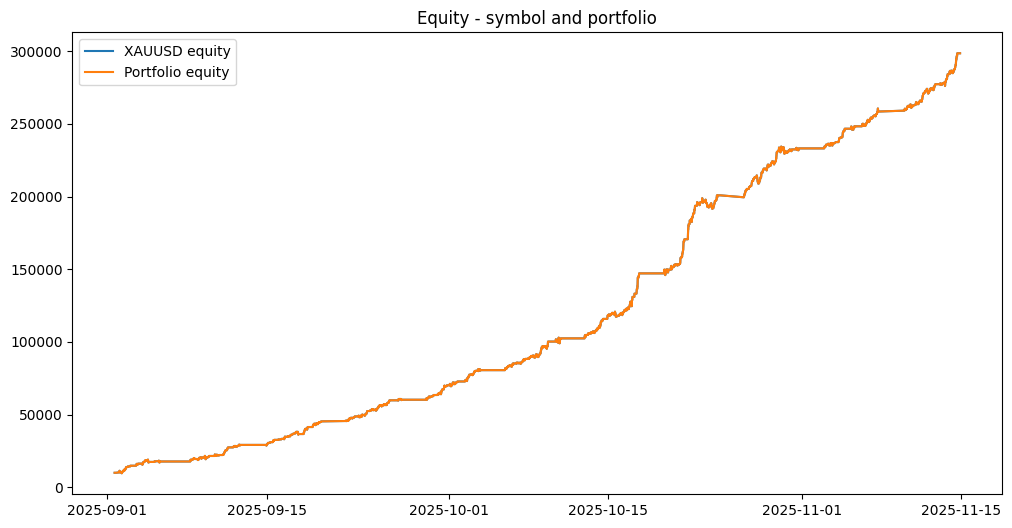

In [ ]:
# backtest_advanced_full.py
# Requires: MetaTrader5, pandas, numpy, matplotlib
# Run inside your activated mt5-env
# python backtest_advanced_full.py

import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from copy import deepcopy

# ----------------------------
# CONFIG
# ----------------------------
MT5_PATH = r"C:\Program Files\MetaTrader 5 EXNESS\terminal64.exe"
# SYMBOLS = ["XAUUSD", "EURUSD", "GBPUSD"]
SYMBOLS = ["XAUUSD"]
TIMEFRAME = mt5.TIMEFRAME_M15
BARS = 5000

INITIAL_BALANCE = 10000.0
RISK_PER_TRADE = 0.01
MAX_TRADES = 1

SEARCH_SPACE = {
    "ma_fast": (5, 20),
    "ma_slow": (21, 100),
    "atr_mul": (1.0, 3.0),
    "risk_per_trade": (0.005, 0.03),
}

GA_POP = 24
GA_GEN = 30
GA_MUT_PROB = 0.2
GA_CROSS_PROB = 0.7

IS_WINDOW_BARS = 2000
OOS_WINDOW_BARS = 500
WALK_FORWARD_STEP = 500

MC_ITER = 200

# ----------------------------
# Utilities
# ----------------------------
def fetch_rates(symbol, bars=BARS, timeframe=TIMEFRAME):
    if not mt5.initialize(MT5_PATH):
        raise RuntimeError("MT5 initialize failed")
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars)
    mt5.shutdown()
    if rates is None or len(rates) == 0:
        raise RuntimeError(f"No data for {symbol}")
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('time')
    return df

def atr_series(df, n=14):
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(n).mean()
    return atr.bfill()

# ----------------------------
# Core backtest engine
# ----------------------------
def run_strategy(df, params, initial_balance=INITIAL_BALANCE):
    df = df.copy()
    ma_fast = params.get('ma_fast', 10)
    ma_slow = params.get('ma_slow', 40)
    atr_mul = params.get('atr_mul', 1.5)
    risk_per_trade = params.get('risk_per_trade', RISK_PER_TRADE)

    df['ma_fast'] = df['close'].rolling(ma_fast).mean()
    df['ma_slow'] = df['close'].rolling(ma_slow).mean()
    df['atr'] = atr_series(df, 14)
    df.dropna(inplace=True)

    pip = 0.0001 if df.index.freq is None or 'D' not in str(df.index.freq) else 0.0001
    equity = initial_balance
    equity_curve = []
    trades = []

    open_trades = []

    for idx, row in df.iterrows():
        # manage open trades
        new_open = []
        for t in open_trades:
            alive = True
            if t['dir'] == 'buy':
                if row['low'] <= t['sl']:
                    pnl = (t['sl'] - t['entry']) * t['lot'] * 10000
                    equity += pnl
                    t['exit'] = t['sl']
                    t['exit_time'] = idx
                    t['pnl'] = pnl
                    t['closed'] = True
                    trades.append(t)
                    alive = False
                else:
                    # TP1-3
                    for tp_key, pct in [('tp1', t['tp1_pct']), ('tp2', t['tp2_pct']), ('tp3', t['tp3_pct'])]:
                        if not t.get(f'hit_{tp_key}', False) and row['high'] >= t[tp_key]:
                            pnl = (t[tp_key]-t['entry'])*t['lot']*10000*pct
                            equity += pnl
                            t[f'hit_{tp_key}'] = True
                            t['realized'] = t.get('realized',0)+pnl
                            if tp_key=='tp3':
                                t['exit'] = t[tp_key]
                                t['exit_time'] = idx
                                t['pnl'] = t['realized']
                                t['closed']=True
                                trades.append(t)
                                alive=False
            else:
                if row['high'] >= t['sl']:
                    pnl = (t['sl'] - t['entry'])*t['lot']*10000
                    equity += pnl
                    t['exit'] = t['sl']
                    t['exit_time'] = idx
                    t['pnl'] = pnl
                    t['closed'] = True
                    trades.append(t)
                    alive = False
                else:
                    for tp_key, pct in [('tp1', t['tp1_pct']), ('tp2', t['tp2_pct']), ('tp3', t['tp3_pct'])]:
                        if not t.get(f'hit_{tp_key}', False) and row['low'] <= t[tp_key]:
                            pnl = (t['entry']-t[tp_key])*t['lot']*10000*pct
                            equity += pnl
                            t[f'hit_{tp_key}']=True
                            t['realized'] = t.get('realized',0)+pnl
                            if tp_key=='tp3':
                                t['exit']=t[tp_key]
                                t['exit_time']=idx
                                t['pnl']=t['realized']
                                t['closed']=True
                                trades.append(t)
                                alive=False
            if alive:
                new_open.append(t)
        open_trades = new_open

        # open new trade
        if len(open_trades)<MAX_TRADES:
            sig = 0
            if row['ma_fast']>row['ma_slow']:
                sig=1
            elif row['ma_fast']<row['ma_slow']:
                sig=-1
            if sig!=0:
                atr = row['atr'] if row['atr']>0 else df['atr'].median()
                sl_dist = atr*atr_mul
                entry = row['close']
                risk_amount = equity*risk_per_trade
                lot = max(0.01, risk_amount/(sl_dist/pip*10))
                if sig==1:
                    sl = entry-sl_dist
                    tp1,tp2,tp3 = entry+sl_dist*1, entry+sl_dist*2, entry+sl_dist*3
                else:
                    sl = entry+sl_dist
                    tp1,tp2,tp3 = entry-sl_dist*1, entry-sl_dist*2, entry-sl_dist*3
                trade = {
                    "symbol": row.name,
                    "entry_time": idx,
                    "dir":"buy" if sig==1 else "sell",
                    "entry":entry,
                    "sl":sl,
                    "tp1":tp1,
                    "tp2":tp2,
                    "tp3":tp3,
                    "lot":lot,
                    "tp1_pct":0.5,
                    "tp2_pct":0.3,
                    "tp3_pct":0.2,
                    "hit_tp1":False,
                    "hit_tp2":False,
                    "hit_tp3":False,
                    "closed":False
                }
                open_trades.append(trade)
        equity_curve.append(equity)

    # close remaining trades
    last_price = df['close'].iloc[-1]
    for t in open_trades:
        if not t.get('closed',False):
            pnl = (last_price-t['entry'])*t['lot']*10000 if t['dir']=='buy' else (t['entry']-last_price)*t['lot']*10000
            t['exit']=last_price
            t['exit_time']=df.index[-1]
            t['pnl']=pnl
            trades.append(t)
            equity+=pnl

    return pd.Series(equity_curve, index=df.index[:len(equity_curve)]), trades

# ----------------------------
# Risk-adjusted & trade analytics
# ----------------------------
def compute_risk_adjusted_metrics(equity_series, risk_free_rate=0.0):
    returns = equity_series.pct_change().dropna()
    if len(returns)<2:
        return {"sharpe":np.nan,"sortino":np.nan}
    mean_r = returns.mean() - risk_free_rate/252
    std_r = returns.std()
    downside = returns[returns<0].std()
    sharpe = mean_r/std_r*np.sqrt(252) if std_r!=0 else np.nan
    sortino = mean_r/downside*np.sqrt(252) if downside!=0 else np.nan
    return {"sharpe":sharpe,"sortino":sortino}

def trade_analytics(trades):
    if not trades:
        return {}
    durations = [(t['exit_time']-t['entry_time']).total_seconds()/3600 for t in trades]
    pl = [t['pnl'] for t in trades]
    winners = [p for p in pl if p>0]
    losers = [p for p in pl if p<=0]
    return {
        "avg_duration_hours": np.mean(durations),
        "median_duration_hours": np.median(durations),
        "winners_count":len(winners),
        "losers_count":len(losers),
        "avg_win":np.mean(winners) if winners else 0,
        "avg_loss":np.mean(losers) if losers else 0,
        "win_rate":len(winners)/len(pl)
    }

def metrics_from_trades(trades, equity_series=None, initial_balance=INITIAL_BALANCE):
    pl = [t.get('pnl',0) for t in trades]
    if not pl:
        return {}
    total=sum(pl)
    wins=[p for p in pl if p>0]
    losses=[p for p in pl if p<=0]
    win_rate=len(wins)/len(pl)
    pf=(sum(wins)/abs(sum(losses))) if sum(losses)!=0 else np.inf
    avg_win=np.mean(wins) if wins else 0
    avg_loss=np.mean(losses) if losses else 0
    expectancy=win_rate*avg_win+(1-win_rate)*avg_loss
    cum=np.cumsum(pl)+initial_balance
    dd=(cum/np.maximum.accumulate(cum)-1).min()
    metrics={"trades":len(pl),"total_pnl":total,"win_rate":win_rate,"profit_factor":pf,
             "expectancy":expectancy,"max_drawdown":dd}
    if equity_series is not None:
        metrics.update(compute_risk_adjusted_metrics(equity_series))
    metrics.update(trade_analytics(trades))
    return metrics

# ----------------------------
# Monte Carlo
# ----------------------------
def monte_carlo_trade_shuffle(trades,n=MC_ITER,initial_balance=INITIAL_BALANCE):
    pl=[t.get('pnl',0) for t in trades]
    results=[]
    for _ in range(n):
        random.shuffle(pl)
        results.append(initial_balance+sum(pl))
    return np.array(results)

# ----------------------------
# GA Optimization
# ----------------------------
def random_individual(space):
    ind={}
    for k,(a,b) in space.items():
        if isinstance(a,int) and isinstance(b,int):
            ind[k]=random.randint(a,b)
        else:
            ind[k]=random.uniform(a,b)
    return ind

def mutate(ind,space,prob=GA_MUT_PROB):
    child=ind.copy()
    for k,(a,b) in space.items():
        if random.random()<prob:
            if isinstance(a,int):
                child[k]=max(a,min(b,child[k]+random.randint(-3,3)))
            else:
                child[k]=max(a,min(b,child[k]+random.uniform(-(b-a)*0.1,(b-a)*0.1)))
    return child

def crossover(a,b):
    return {k:a[k] if random.random()<0.5 else b[k] for k in a.keys()}

def evaluate_params(params, symbol_df):
    eq,trades=run_strategy(symbol_df,params)
    mets=metrics_from_trades(trades, eq)
    if mets.get('trades',0)==0:
        return -1e6
    fitness=mets.get('total_pnl',0)-abs(mets.get('max_drawdown',0))*100
    return fitness

def tournament_select(pop,scores,k=3):
    sel=random.sample(list(zip(pop,scores)),k)
    sel_sorted=sorted(sel,key=lambda x:x[1],reverse=True)
    return deepcopy(sel_sorted[0][0])

def ga_optimize(symbol_df,space,pop=GA_POP,gen=GA_GEN):
    population=[random_individual(space) for _ in range(pop)]
    scores=[evaluate_params(ind,symbol_df) for ind in population]
    for g in range(gen):
        new_pop=[]
        ranked=sorted(zip(scores,population),key=lambda x:x[0],reverse=True)
        elite=[p for s,p in ranked[:max(1,pop//8)]]
        new_pop.extend(elite)
        while len(new_pop)<pop:
            p1=tournament_select(population,scores)
            p2=tournament_select(population,scores)
            if random.random()<GA_CROSS_PROB:
                child=crossover(p1,p2)
            else:
                child=deepcopy(p1)
            child=mutate(child,space)
            new_pop.append(child)
        population=new_pop
        scores=[evaluate_params(ind,symbol_df) for ind in population]
        best_score=max(scores)
        print(f"GA gen {g+1}/{gen} best {best_score:.2f}")
    best_idx=int(np.argmax(scores))
    return population[best_idx], scores[best_idx]

# ----------------------------
# Walk-forward
# ----------------------------
def walk_forward(symbol_df, space, is_window=IS_WINDOW_BARS, oos_window=OOS_WINDOW_BARS, step=WALK_FORWARD_STEP):
    results=[]
    n=len(symbol_df)
    start=0
    while start+is_window+oos_window<=n:
        is_df=symbol_df.iloc[start:start+is_window]
        oos_df=symbol_df.iloc[start+is_window:start+is_window+oos_window]
        print(f"WF: IS {start}->{start+is_window} | OOS {start+is_window}->{start+is_window+oos_window}")
        best_params, score = ga_optimize(is_df, space, pop=16, gen=8)
        eq, trades=run_strategy(oos_df,best_params)
        mets=metrics_from_trades(trades, eq)
        results.append({"is_params":best_params,"is_score":score,"oos_metrics":mets,"oos_trades":trades})
        start+=step
    return results

# ----------------------------
# Portfolio runner
# ----------------------------
def run_portfolio(symbols, params_map):
    equities={}
    trades_all={}
    for s in symbols:
        print("Fetching",s)
        df=fetch_rates(s)
        params=params_map.get(s,params_map.get("default",{"ma_fast":10,"ma_slow":40,"atr_mul":1.5,"risk_per_trade":RISK_PER_TRADE}))
        eq,trades=run_strategy(df,params)
        equities[s]=eq
        trades_all[s]=trades
    eq_df=pd.DataFrame(equities).fillna(method='ffill').fillna(method='bfill')
    eq_df['portfolio']=eq_df.sum(axis=1)
    return eq_df,trades_all

# ----------------------------
# MAIN EXECUTION
# ----------------------------
def main():
    print("=== BACKTEST ADVANCED START ===")
    sym=SYMBOLS[0]
    df=fetch_rates(sym, bars=BARS)
    print("Data loaded:", len(df), "bars")
    
    base_params={"ma_fast":10,"ma_slow":40,"atr_mul":1.5,"risk_per_trade":RISK_PER_TRADE}
    eq,trades=run_strategy(df,base_params)
    print("Baseline metrics:", metrics_from_trades(trades, eq))
    
    best_params,best_score=ga_optimize(df,SEARCH_SPACE,pop=GA_POP,gen=GA_GEN)
    print("GA best params:",best_params,"score:",best_score)
    
    eq_best,trades_best=run_strategy(df,best_params)
    metrics_best=metrics_from_trades(trades_best, eq_best)
    print("\n=== Evaluation of Best GA Parameters ===")
    for k,v in metrics_best.items():
        print(f"{k}: {v}")
    
    print("Starting walk-forward analysis...")
    wf_results=walk_forward(df, SEARCH_SPACE)
    
    mc=monte_carlo_trade_shuffle(trades_best, n=MC_ITER)
    print("Monte Carlo final equity percentiles:", np.percentile(mc,[5,25,50,75,95]))
    
    params_map={s:best_params for s in SYMBOLS}
    eq_df,trades_all=run_portfolio(SYMBOLS,params_map)
    
    plt.figure(figsize=(12,6))
    plt.plot(eq_best.index, eq_best.values, label=f"{sym} equity")
    plt.plot(eq_df.index, eq_df['portfolio'].values, label="Portfolio equity")
    plt.legend()
    plt.title("Equity - symbol and portfolio")
    plt.show()

if __name__=="__main__":
    main()
